In [1]:
%load_ext autoreload
%autoreload 2

from methods import CLIP

C:\Users\babak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

import torch.nn.functional as F
from torchvision.transforms import ToTensor

from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("patrickjohncyh/fashion-clip")
model = AutoModelForZeroShotImageClassification.from_pretrained("patrickjohncyh/fashion-clip")
model.to('cuda')  # Move model to GPU

C:\Users\babak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [4]:
myclip = CLIP(processor, model)

Cannot identify image file: data/compressed-fashion/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
Cannot identify image file: data/compressed-fashion/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
Cannot identify image file: data/compressed-fashion/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
Cannot identify image file: data/compressed-fashion/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
Cannot identify image file: data/compressed-fashion/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
Cannot identify image file: data/compressed-fashion/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg


In [5]:
image = myclip.all_images[0]

In [6]:
len(myclip.all_images)

5757

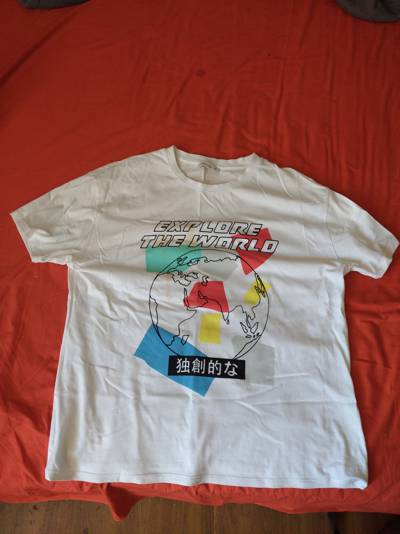

In [7]:
image

In [8]:
my_class_list = ['brown','cat','pants','black', 'hat' , 'dog', 'shoes']
probs = myclip.image_classification(image, my_class_list)
probs

{'brown': 0.012347032316029072,
 'cat': 0.8710525631904602,
 'pants': 0.022934453561902046,
 'black': 0.025153856724500656,
 'hat': 0.01092295628041029,
 'dog': 0.05561224743723869,
 'shoes': 0.0019768914207816124}

In [9]:
all_images_vector = myclip.embedder()

In [10]:
len(all_images_vector)

5757

In [46]:
class_list = ['jeans']
inputs = processor(images = image, text = class_list, return_tensors = "pt", padding = True)
inputs = {key: value.to('cuda') for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

In [47]:
concept_embedding = outputs.text_embeds

In [48]:
all_images_vector.shape

torch.Size([5757, 512])

In [49]:
# find the cosine similarity between all_tshirt_vector and concept_embedding
similarity = F.cosine_similarity(all_images_vector, concept_embedding).cpu().numpy()

In [50]:
# apply softmax to the similarity scores
scores = F.softmax(torch.tensor(similarity), dim=0).numpy()
# find the top 5 scores and their corresponding indices
top_scores, top_indices = torch.topk(torch.tensor(scores), 5)

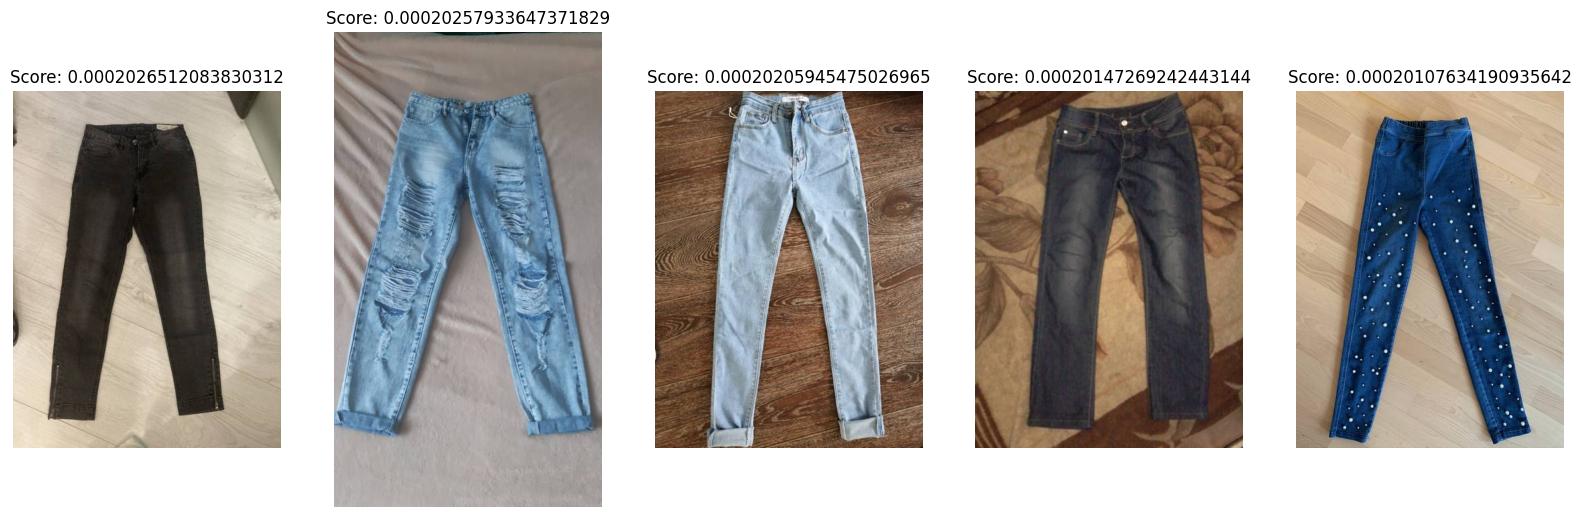

In [51]:
# show the images in the top 5 indices
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, idx in enumerate(top_indices):
    img = myclip.all_images[idx]
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Score: {top_scores[i].item()}")
plt.show()

In [52]:
search_vector, top_scores = myclip.recursive_search(all_images_vector, concept_embedding)

bestof_batch shape before recursion or final selection: torch.Size([1440, 512])
bestof_batch shape before recursion or final selection: torch.Size([360, 512])
bestof_batch shape before recursion or final selection: torch.Size([90, 512])
bestof_batch shape before recursion or final selection: torch.Size([25, 512])
top_indices: tensor([20, 21,  5, 10, 15], device='cuda:0')
top_scores: tensor([0.0404, 0.0404, 0.0403, 0.0402, 0.0401], device='cuda:0')
final bestof_batch shape: torch.Size([25, 512])


In [54]:
# search for search_vector in all_images  _vector and return their indices
indices = [] 
for vector in search_vector:
    print(vector.shape)
    for index, item in enumerate(all_images_vector):
        if torch.equal(vector, item):
            indices.append(index)
            break

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])


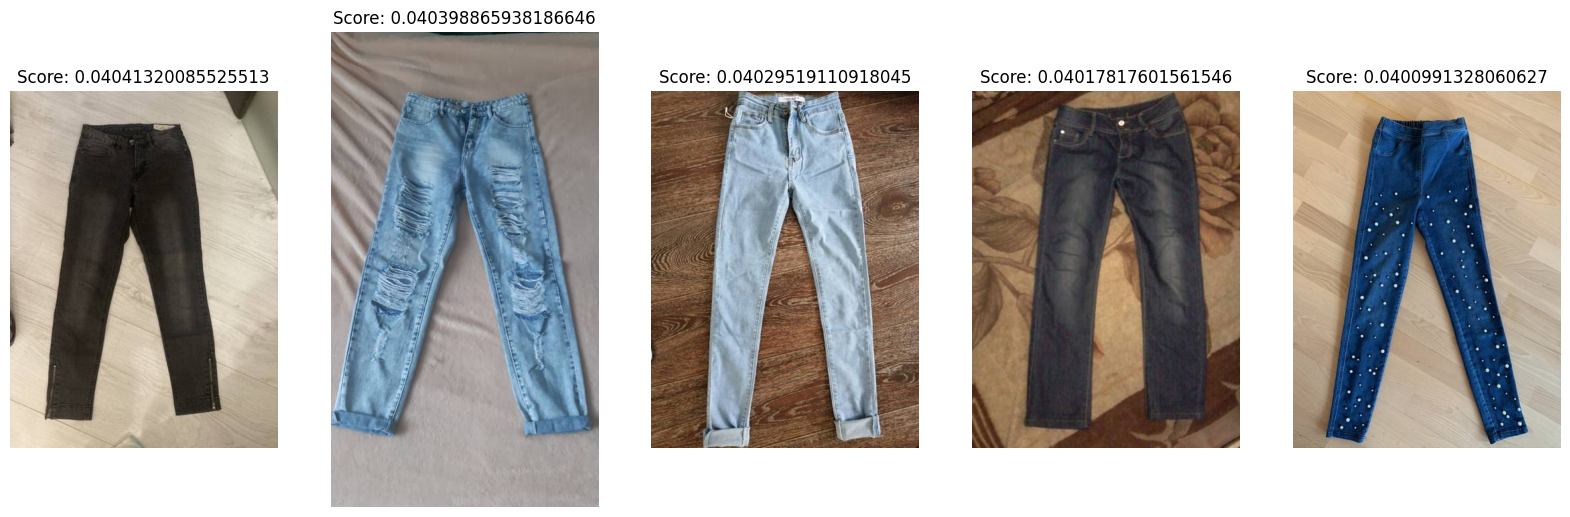

In [55]:
# show the images in the top 5 indices
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, idx in enumerate(indices):
    img = myclip.all_images[idx]
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Score: {top_scores[i].item()}")
plt.show()

In [172]:
imgs = []
# loop through each folder and read all images

for image in os.listdir('user-input/'):
    try:
        img = Image.open('user-input/' + image)
        imgs.append(img)
    except UnidentifiedImageError:
        print(f"Cannot identify image file")

#self.all_images = imgs['user-input']

In [173]:
#image = np.mean(imgs)

In [174]:
class_list = ['jeans']
inputs = processor(images = imgs, text = class_list, return_tensors = "pt", padding = True)
inputs = {key: value.to('cuda') for key, value in inputs.items()}
model.to('cuda')
with torch.no_grad():
    outputs = model(**inputs)

In [175]:
userimage_embedding = outputs.image_embeds

In [176]:
userimage_embedding.shape

torch.Size([4, 512])

In [177]:
average_embedding = userimage_embedding.mean(dim=0, keepdim=True)

In [178]:
userimage_embedding = average_embedding

In [179]:
userimage_embedding.shape

torch.Size([1, 512])

In [180]:
# find the cosine similarity between all_tshirt_vector and concept_embedding
similarity = F.cosine_similarity(all_images_vector, userimage_embedding).cpu().numpy()
# apply softmax to the similarity scores
scores = F.softmax(torch.tensor(similarity), dim=0).numpy()
# find the top 5 scores and their corresponding indices
top_scores, top_indices = torch.topk(torch.tensor(scores), 5)

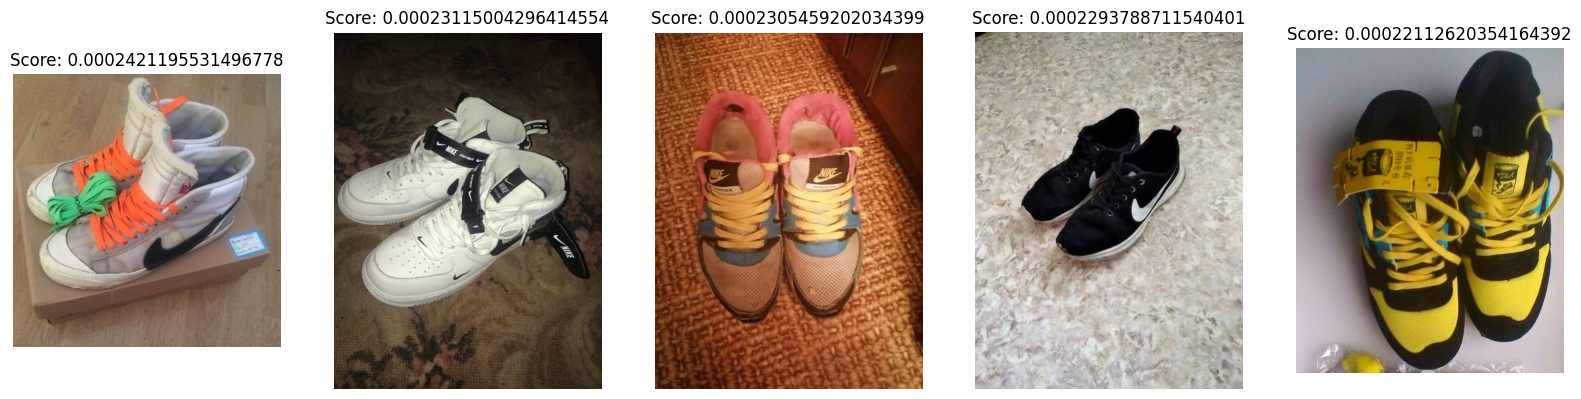

In [181]:
# show the images in the top 5 indices
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, idx in enumerate(top_indices):
    img = myclip.all_images[idx]
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Score: {top_scores[i].item()}")
plt.show()

In [182]:
search_vector, top_scores = myclip.recursive_search(all_images_vector, userimage_embedding)

bestof_batch shape before recursion or final selection: torch.Size([1440, 512])
bestof_batch shape before recursion or final selection: torch.Size([360, 512])
bestof_batch shape before recursion or final selection: torch.Size([90, 512])
bestof_batch shape before recursion or final selection: torch.Size([25, 512])
top_indices: tensor([ 5, 10, 11, 15, 12], device='cuda:0')
top_scores: tensor([0.0443, 0.0423, 0.0422, 0.0420, 0.0405], device='cuda:0')
final bestof_batch shape: torch.Size([25, 512])


In [183]:
# search for search_vector in all_images  _vector and return their indices
indices = [] 
for vector in search_vector:
    print(vector.shape)
    for index, item in enumerate(all_images_vector):
        if torch.equal(vector, item):
            indices.append(index)
            break

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])


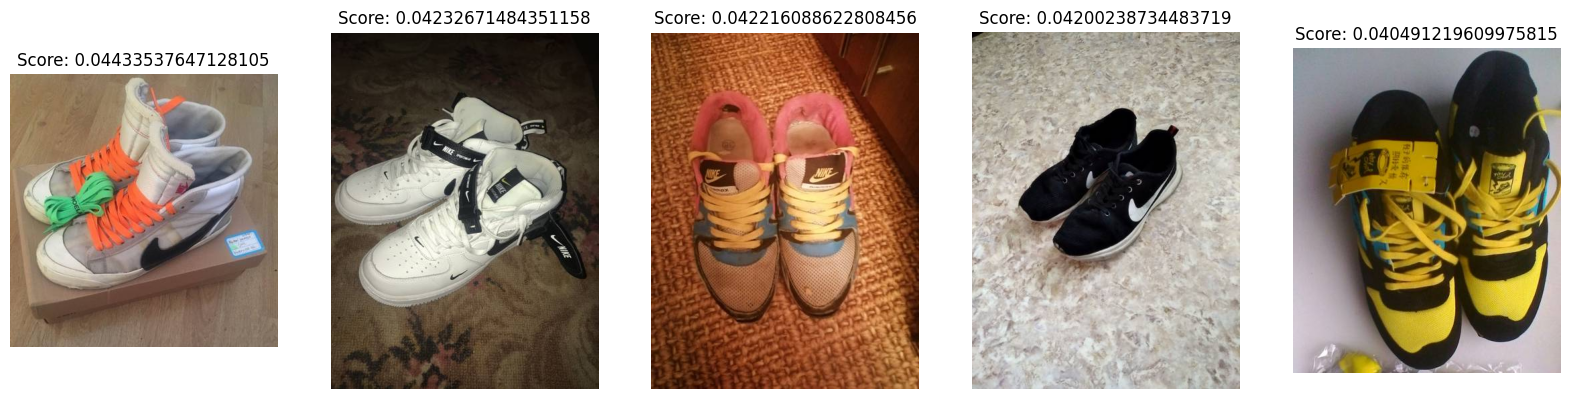

In [184]:
# show the images in the top 5 indices
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, idx in enumerate(indices):
    img = myclip.all_images[idx]
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Score: {top_scores[i].item()}")
plt.show()